<center><h1>Laboratory of Computational Physics - Group Project</h1></center>
<center><h2>Dormant Black Holes in Binary Systems</h2></center>

<center><h2>Group 2307</h2></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name        | First Name         |Matricola number|
|:----------------:|:------------------:|:--------------:|
| Bertinelli       | Gabriele           |1219907 (tri)   |
| Cacciola         | Martina            |2097476         |
| Pervysheva       | Yelyzaveta         |2039398         |           
| Waththe Liyanage | Wageesha Widuranga |2078719         |
|Wickramasinghe Wickramasinghe Mudiyanselage |Poornima Amali | 2088370 |

## OBJECTIVE : FIND SIMILAR SYSTEMS TO THE REAL CANDIDATES OF BH-MS BINARY SYSTEMS AND PREDICTING THE HISTORY OF THE EVOLUTION

### 1) Abstract



The objective of this part is to uncover similar systems within a collection of simulated BH-MS binary systems that closely
resemble the selected real candidates. Through a comprehensive comparative analysis utilizing key parameters such as the
mass of the black hole, mass of the main sequence star, and period, the most similar systems are identified. Furthermore,
leveraging the data from the most similar 1000 simulation systems, the study predicts the historical evolution of the 
selected real candidates, encompassing potential occurrences of common envelope phases, mass transfer processes, and
non-interactive phases.By analyzing key properties in the 10 most similar systems from the SEVN simulation, mean values are
calculated to represent possible evolution histories for the real candidates. Leveraging the knowledge and patterns
obtained, informed predictions are made about the likely characteristics and trajectory of the real candidate systems 
throughout their evolutionary journeys.


### 2) Method

#### Part 1 - Calculating the similarity of the Sevn simulated systems to the real candidate



The objective of this phase is to identify systems in the SEVN simulation that closely resemble the selected real
candidates. To achieve this, we employ a quantitative approach utilizing the following equation, which calculates
the similarity between systems based on the Mass of the Black hole, Mass of the Main sequence star, and the period:
    
d_(Sevn,Real) = [((〖Sec_M〗_Sevn-〖Sec_M〗_R)/(〖S_M〗_upper-〖S_M〗_lower ))^2+((〖MS_M〗_Sevn-〖MS_M〗_R)/(〖MS_M〗_upper-〖MS_M〗_lower ))^2+((P_Sevn-P_R)/(P_upper-P_lower ))^2 ]^(1/2)

Here, the variables denote the following:
- Sec_M: Mass of the black hole
- MS_M: Mass of the main sequence star
- P: Period of the binary system

In each property, difference between the simulation data value and the real data value is divided by the difference between the upper and lower values of the Gaia real candidate. By dividing the difference between the simulation data value and the real data value by the difference between the upper and lower values of the Gaia real candidate, the aim is to scale the values and remove the unit dependency. This scaling process allows for a consistent and meaningful comparison of the properties between the simulation and real data, enabling the identification of similarities and patterns.






In [1]:
import pandas as pd
import numpy as np
from astropy import constants as const
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
import dask
import dask.dataframe as dd

In [2]:
# load the real data set
real_data = pd.read_csv('msco_candidates_real_data.csv')

# load sevn dataset - BHMS systems (non-interracting)
data1 = pd.read_csv('data_z02_001_0001_a05.csv')
data2 = pd.read_csv('data_z02_001_0001_a1.csv')
data3 = pd.read_csv('data_z02_001_0001_a5.csv')

# Concatenate the dataframes
sevn_data= pd.concat([data1,data2,data3])

# Reset the index of the combined dataframe
sevn_data = sevn_data.reset_index(drop=True)

print(len(sevn_data))
print(len(real_data))

2259570
4641


In [3]:
# get Period in the simulation datasets in "years"

sevn_data['P'] = (10**(sevn_data['logP']))/365.25

sevn_data.head(3)

,Unnamed: 0,ID,name,Mass_BH,Mass_1,Eccentricity,logP,z,alpha,BEvent,type,elapsed_bwt,tot_mass,P
0,0,80,0_201673565337120,17.66923,28.74325,0.212435,4.221513,0.02,0.5,-1,NI,1.621285,46.41248,45.595603
1,1,87,0_929528790266714,23.50375,44.82448,0.752931,5.343398,0.02,0.5,-1,NI,0.180697,68.32823,603.681288
2,2,109,0_889165204871227,21.41187,34.20442,0.227290,4.468927,0.02,0.5,-1,NI,0.026888,55.61629,80.600274


#### Changes to real dataset

###### q = secondary_mass/MS_mass

In [4]:
# calculate the mass of the MS in the real data and add it as a new column
real_data['MS_mass'] = real_data['secondary_mass'] /real_data['q']

# Calculate the upper and lower values for MS mass
real_data['MS_mass_upper'] = real_data['secondary_mass_upper']/real_data['q_lower']
real_data['MS_mass_lower'] = real_data['secondary_mass_lower']/real_data['q_upper']

real_data.head(2)

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,secondary_mass_lower,secondary_mass_upper,P,P_lower,P_upper,plating,ruwe_spec,MS_mass,MS_mass_upper,MS_mass_lower
0,1.636150e+18,Gaia DR3 38223381426,3.822340e+17,1245583346,2016,5.850188,0.026632,43.151286,0.011671,1.973182,...,3.399461,8.765234,0.051509,0.021995,0.067534,gold,11.445850,1.245597,3.140019,0.472308
1,1.636150e+18,Gaia DR3 39348278029,3.934830e+17,1053113768,2016,0.617178,0.027540,49.364785,0.030014,3.079333,...,4.101095,27.579153,0.032462,0.014372,0.043155,gold,30.949878,0.976457,6.343892,0.140279


#### Our intention is to find similar systems for a selected system in the real dataset. So, we compare our data with the data of the selected row in the real dataset.


In [5]:
# by changing the index_num value, we can select different rows in the real candidiate csv file (0-4641)
index_num = 1

# get the selected row of the real dataset
real_x =  real_data.loc[index_num, 'secondary_mass']
real_y =  real_data.loc[index_num, 'MS_mass']
real_z =  real_data.loc[index_num, 'P']

# get the difference of upper and lower values
d_x =  real_data.loc[index_num, 'secondary_mass_upper'] - real_data.loc[index_num, 'secondary_mass_lower']
d_y =  real_data.loc[index_num, 'MS_mass_upper'] - real_data.loc[index_num, 'MS_mass_lower']
d_z =  real_data.loc[index_num, 'P_upper'] - real_data.loc[index_num, 'P_lower'] 
 
print(real_x,real_y,real_z)
print(d_x,d_y,d_z)

# define the selected row with necessary columns
df1 = real_data[['solution_id','secondary_mass','secondary_mass_upper','secondary_mass_lower','MS_mass','MS_mass_upper','MS_mass_lower','P','P_upper','P_lower']]

# define the selected row with necessary columns we use 
df2 = real_data[['solution_id','secondary_mass','MS_mass','P']]

# print the first row of df2
df2.iloc[index_num]

20.24763186 0.9764565289187651 0.032462397
23.478057894 6.203612587244908 0.028783042


solution_id       1.636150e+18
secondary_mass    2.024763e+01
MS_mass           9.764565e-01
P                 3.246240e-02
Name: 1, dtype: float64

#### Calculation 

In [6]:
# define two null lists
m =[]
n=[]

# get the values for the entire sorted sevn dataset (name and the d_all value)
for index, row in sevn_data.iterrows():
    a = row['Mass_BH']  
    b = row['Mass_1']
    c =  row['P']
    d = row['name']
    e = row['z']
    f = row['alpha']
    g = row['type']
    
    d_mass_BH = ((a-real_x)/d_x)**2 

    d_mass_MS = ((b-real_y)/d_y)**2

    d_P = ((c-real_z)/d_z)**2

    d_all = np.sqrt(d_mass_BH+d_mass_MS+d_P)
    
    # add values to the lists
    n.append((d_mass_BH,d_mass_MS,d_P,d_all))
    m.append((d,a,b,c,e,f,d_all,g))


In [7]:
print(index_num)

1


In [8]:
## Get the closest 10 systems in the 3D space 

sorted_list = sorted(m, key=lambda x: x[6])  # Sort the list based on the seventh column
smallest_values = sorted_list[:10]  # Get the 10 smallest values

corresponding_names = [row[0] for row in smallest_values]  # Get the corresponding values from the first column
corresponding_Mass_BH = [row[1] for row in smallest_values]
corresponding_Mass_1 = [row[2] for row in smallest_values]
corresponding_P = [row[3] for row in smallest_values] 
corresponding_z = [row[4] for row in smallest_values]  
corresponding_alpha = [row[5] for row in smallest_values]
corresponding_type = [row[7] for row in smallest_values]
corresponding_values = [row[6] for row in smallest_values]

# Create the DataFrame

final_data = pd.DataFrame({
    'Name': corresponding_names,
    'Mass_BH': corresponding_Mass_BH,
    'Mass_1': corresponding_Mass_1,
    'P' : corresponding_P,
    'z': corresponding_z,
    'alpha': corresponding_alpha,
    'type' : corresponding_type,
    'value': corresponding_values
})

print(df2.iloc[index_num])

final_data




solution_id       1.636150e+18
secondary_mass    2.024763e+01
MS_mass           9.764565e-01
P                 3.246240e-02
Name: 1, dtype: float64


,Name,Mass_BH,Mass_1,P,z,alpha,type,value
0,0_345196779256754,14.65735,3.467173,0.031774,0.001,1.0,CE,0.467402
1,0_404285897131853,14.45549,3.518977,0.034329,0.001,1.0,CE,0.482742
2,0_333015430124277,15.09946,3.601238,0.035011,0.001,1.0,CE,0.484709
3,0_242498891492866,13.96893,3.396002,0.028451,0.001,1.0,CE,0.493012
4,0_878189746846279,14.30110,3.427026,0.037040,0.001,5.0,CE,0.495469
5,0_624411359463969,13.31346,3.345066,0.029244,0.001,1.0,CE,0.495495
6,0_325319183437822,12.32007,3.239131,0.032820,0.001,5.0,CE,0.497191
7,0_268401914983397,12.16869,3.222125,0.032706,0.001,5.0,CE,0.499520
8,0_927008247495079,14.14598,3.628059,0.033443,0.001,1.0,CE,0.501396
9,0_601048714020608,15.82984,3.754069,0.036131,0.001,5.0,CE,0.502118


In [9]:
## Get the smallest 1000 values in the list

sorted_list = sorted(m, key=lambda x: x[6])  # Sort the list based on the seventh column
smallest_values = sorted_list[:1000]  # Get the 1000 smallest values

corresponding_names = [row[0] for row in smallest_values]  # Get the corresponding values from the first column
corresponding_Mass_BH = [row[1] for row in smallest_values]
corresponding_Mass_1 = [row[2] for row in smallest_values]
corresponding_P = [row[3] for row in smallest_values] 
corresponding_z = [row[4] for row in smallest_values]  
corresponding_alpha = [row[5] for row in smallest_values]
corresponding_values = [row[6] for row in smallest_values]
corresponding_type = [row[7] for row in smallest_values]

# Create the DataFrame

final_data_1000 = pd.DataFrame({
    'Name': corresponding_names,
    'Mass_BH': corresponding_Mass_BH,
    'Mass_1': corresponding_Mass_1,
    'P' : corresponding_P,
    'z': corresponding_z,
    'alpha': corresponding_alpha,
    'value': corresponding_values,
    'type' :corresponding_type
})

print(df2.iloc[index_num])

final_data_1000.head(3)

solution_id       1.636150e+18
secondary_mass    2.024763e+01
MS_mass           9.764565e-01
P                 3.246240e-02
Name: 1, dtype: float64


,Name,Mass_BH,Mass_1,P,z,alpha,value,type
0,0_345196779256754,14.65735,3.467173,0.031774,0.001,1.0,0.467402,CE
1,0_404285897131853,14.45549,3.518977,0.034329,0.001,1.0,0.482742,CE
2,0_333015430124277,15.09946,3.601238,0.035011,0.001,1.0,0.484709,CE


In [10]:
# getting necessary columns as lists for plotting - for 10

Mass_BH = final_data['Mass_BH'].tolist()
Mass_1 = final_data['Mass_1'].tolist()
P = final_data['P'].tolist()



In [11]:
# getting necessary columns as lists for plotting - for 1000

Mass_BH_1000 = final_data_1000['Mass_BH'].tolist()
Mass_1_1000 = final_data_1000['Mass_1'].tolist()
P_1000 = final_data_1000['P'].tolist()
type_1000 = final_data_1000['type'].tolist()


#### Part 2 - Plotting

#### Plot the 10 closest systems to the selected real candidate in 3D space

20.24763186 0.9764565289187651 0.032462397


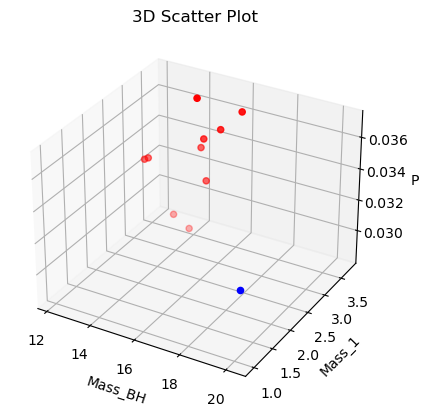

In [12]:
# Three lists representing X, Y, and Z coordinates
x = Mass_BH
y = Mass_1
z = P 

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

print(real_x, real_y, real_z)

# Plot the points
ax.scatter(x, y, z, c='r', marker='o')
ax.scatter(real_x, real_y, real_z, c='b', marker='o')


# Set labels and title
ax.set_xlabel('Mass_BH')
ax.set_ylabel('Mass_1')
ax.set_zlabel('P')
ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()


#### Plot the 1000 closest systems to the selected real candidate in 2D space

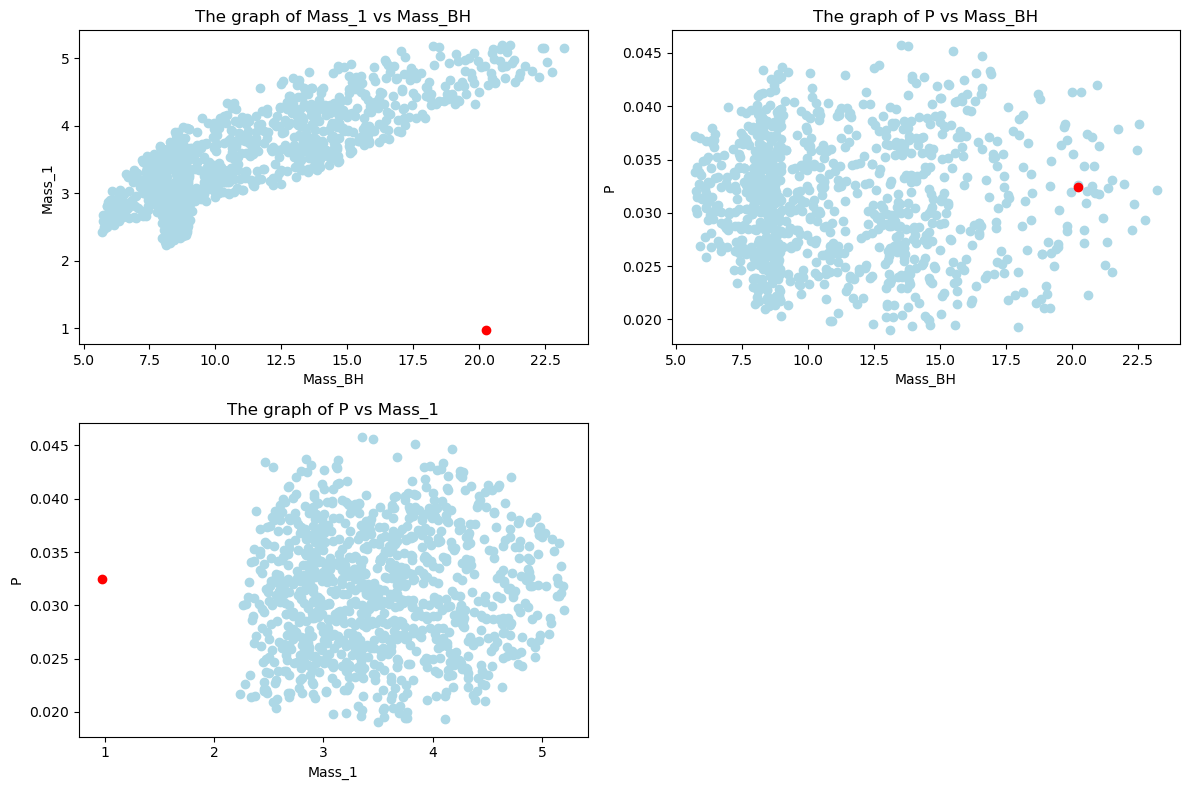

In [14]:
# Existing scatter plot with multiple points
x = Mass_BH
y = Mass_1
z = P

# plot smallest 1000
x_1000 = Mass_BH_1000
y_1000 = Mass_1_1000
z_1000 = P_1000

# Coordinates of the starting point
start_x = real_x
start_y = real_y
start_z = real_z

# Selected candidate
x_common = start_x
y_common = start_y
z_common = start_z

# Data for the individual subplots
x1 = x_1000
y1 = y_1000

x2 = x_1000
y2 = z_1000

x3 = y_1000
y3 = z_1000

# Create a figure with three subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot the first subplot
axs[0, 0].scatter(x1, y1, color='lightblue', marker='o')
axs[0, 0].plot(x_common, y_common, color='r', marker='o')
axs[0, 0].set_title('The graph of Mass_1 vs Mass_BH')
axs[0, 0].set_xlabel('Mass_BH')
axs[0, 0].set_ylabel('Mass_1')

# Plot the second subplot
axs[0, 1].scatter(x2, y2, color='lightblue', marker='o')
axs[0, 1].plot(x_common, z_common, color='r', marker='o')
axs[0, 1].set_title('The graph of P vs Mass_BH')
axs[0, 1].set_xlabel('Mass_BH')
axs[0, 1].set_ylabel('P')

# Plot the third subplot
axs[1, 0].scatter(x3, y3, color='lightblue', marker='o')
axs[1, 0].plot(y_common, z_common, color='r', marker='o')
axs[1, 0].set_title('The graph of P vs Mass_1')
axs[1, 0].set_xlabel('Mass_1')
axs[1, 0].set_ylabel('P')

# Hide the empty subplot in the second row
axs[1, 1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()




#### Plot the 1000 closest systems to the selected real candidate in 3D space

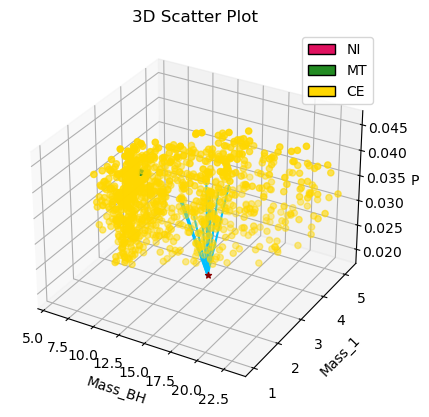

In [15]:
# Existing scatter plot with multiple points
x = Mass_BH
y = Mass_1
z = P

# plot smallest 1000
x_1000 = Mass_BH_1000
y_1000 = Mass_1_1000
z_1000 = P_1000

# Coordinates of the starting point
start_x = real_x
start_y = real_y
start_z = real_z

# Map types to colors
type_colors = {
    'NI': '#E0115F',  # 'CE' type will be plotted in black
    'MT': '#228B22',  # 'MT' type will be plotted in magenta
    'CE': '#FFD700'   # 'NI' type will be plotted in yellow
}

# Convert type_1000 to colors
colors = [type_colors.get(t, 'c') for t in type_1000]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the existing points
ax.scatter(x, y, z, c='#F5F5DC', marker='o')  # Plot the existing points
ax.scatter(start_x, start_y, start_z, c='#8B0000', marker='*')  # Plot the starting point
ax.scatter(x_1000, y_1000, z_1000, c=colors, marker='o')  # Plot the 1000 points

# Loop over the existing points and draw lines to the starting point
for i in range(len(x)):
    ax.plot([start_x, x[i]], [start_y, y[i]], [start_z, z[i]], c='#00BFFF')

# Set labels and title
ax.set_xlabel('Mass_BH')
ax.set_ylabel('Mass_1')
ax.set_zlabel('P')
ax.set_title('3D Scatter Plot')

# Create legend handles and labels
legend_handles = [Patch(facecolor=c, edgecolor='k', label=t) for t, c in type_colors.items()]

# Add the legend using the created handles and labels
ax.legend(handles=legend_handles)

# Show the plot
plt.show()


#### Show the plot of the 1000 closest systems to the selected real candidate, in different angles

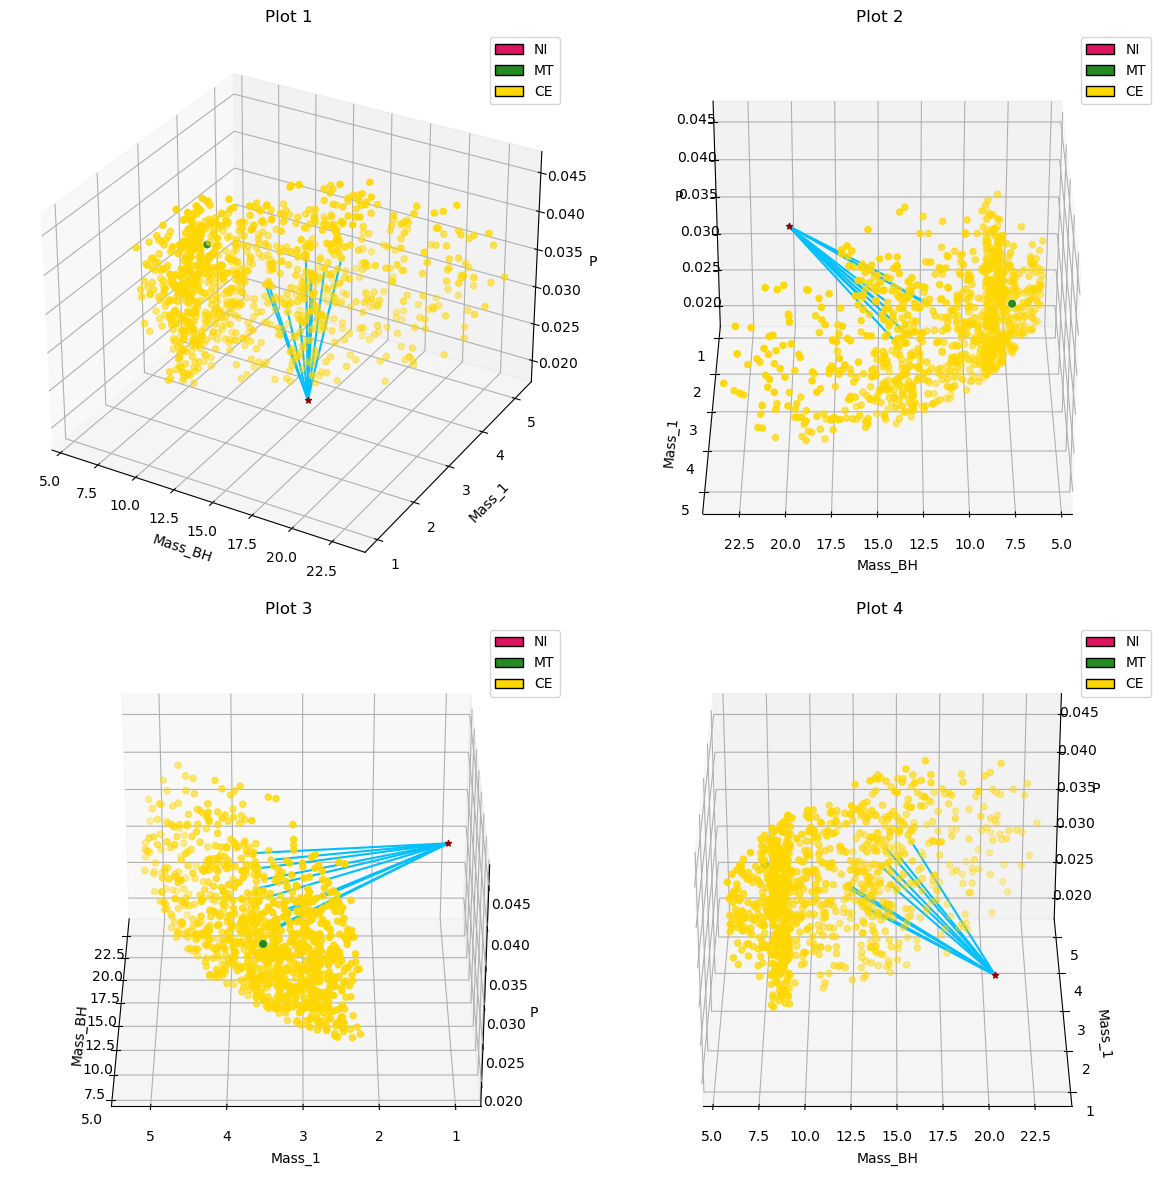

In [16]:
# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})

# Scatter plot 1
ax = axes[0, 0]
ax.scatter(x, y, z, c='#F5F5DC', marker='o')
ax.scatter(start_x, start_y, start_z, c='#8B0000', marker='*')
ax.scatter(x_1000, y_1000, z_1000, c=colors, marker='o')
for i in range(len(x)):
    ax.plot([start_x, x[i]], [start_y, y[i]], [start_z, z[i]], c='#00BFFF')
ax.set_xlabel('Mass_BH')
ax.set_ylabel('Mass_1')
ax.set_zlabel('P')
legend_handles = [Patch(facecolor=c, edgecolor='k', label=t) for t, c in type_colors.items()]# Create legend handles and labels
ax.legend(handles=legend_handles)# Add the legend using the created handles and labels
ax.set_title('Plot 1')

# Scatter plot 2
ax = axes[0, 1]
ax.scatter(x, y, z, c='#F5F5DC', marker='o')
ax.scatter(start_x, start_y, start_z, c='#8B0000', marker='*')
ax.scatter(x_1000, y_1000, z_1000, c=colors, marker='o')
for i in range(len(x)):
    ax.plot([start_x, x[i]], [start_y, y[i]], [start_z, z[i]], c='#00BFFF')
ax.view_init(azim=90)  # Rotate the plot by 90 degrees
ax.set_xlabel('Mass_BH')
ax.set_ylabel('Mass_1')
ax.set_zlabel('P')
legend_handles = [Patch(facecolor=c, edgecolor='k', label=t) for t, c in type_colors.items()]# Create legend handles and labels
ax.legend(handles=legend_handles)# Add the legend using the created handles and labels
ax.set_title('Plot 2')

# Scatter plot 3
ax = axes[1, 0]
ax.scatter(x, y, z, c='#F5F5DC', marker='o')
ax.scatter(start_x, start_y, start_z, c='#8B0000', marker='*')
ax.scatter(x_1000, y_1000, z_1000, c=colors, marker='o')
for i in range(len(x)):
    ax.plot([start_x, x[i]], [start_y, y[i]], [start_z, z[i]], c='#00BFFF')
ax.view_init(azim=180)  # Rotate the plot by 180 degrees
ax.set_xlabel('Mass_BH')
ax.set_ylabel('Mass_1')
ax.set_zlabel('P')
legend_handles = [Patch(facecolor=c, edgecolor='k', label=t) for t, c in type_colors.items()]# Create legend handles and labels
ax.legend(handles=legend_handles)# Add the legend using the created handles and labels
ax.set_title('Plot 3')

# Scatter plot 4
ax = axes[1, 1]
ax.scatter(x, y, z, c='#F5F5DC', marker='o')
ax.scatter(start_x, start_y, start_z, c='#8B0000', marker='*')
ax.scatter(x_1000, y_1000, z_1000, c=colors, marker='o')
for i in range(len(x)):
    ax.plot([start_x, x[i]], [start_y, y[i]], [start_z, z[i]], c='#00BFFF')
ax.view_init(azim=270)  # Rotate the plot by 270 degrees
ax.set_xlabel('Mass_BH')
ax.set_ylabel('Mass_1')
ax.set_zlabel('P')
legend_handles = [Patch(facecolor=c, edgecolor='k', label=t) for t, c in type_colors.items()]# Create legend handles and labels
ax.legend(handles=legend_handles)# Add the legend using the created handles and labels
ax.set_title('Plot 4')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


#### Part 3 - Find the possible history of the selected real candidate system

#### 3a - Get the percentage of the possibility of the type

We predict the history of the selected real candidates, whether they have undergone a common envelope phase, mass transfer, 
or remain non-interactive. We determine this by leveraging the history of the 1000 most similar simulation systems. 
By analyzing their respective histories, we assign a percentage possibility to each scenario for the real candidates. By 
following this methodological approach, we aim to identify and understand the similarities between the SEVN simulation systems
and the real candidates, shedding light on their evolutionary pathways and potential interactions.


In [17]:
# calculating number and percentages of each type (with in the 1000 systems which are closest)

value_counts = final_data_1000['type'].value_counts()
print(value_counts)
print()

percentages = (value_counts / 1000) * 100
print("Percentage of the possibility of each type")
print(percentages)


CE    997
MT      3
Name: type, dtype: int64

Percentage of the possibility of each type
CE    99.7
MT     0.3
Name: type, dtype: float64


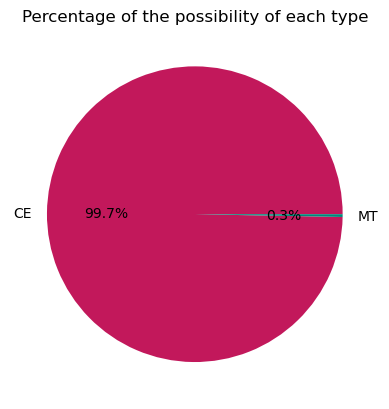

In [18]:
# show percentages in a pie chart

colors = ['#c2185b', '#00897b', '#ffc400']

# Create a pie chart with custom colors
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', colors=colors)

# Add a title
plt.title("Percentage of the possibility of each type")

# Display the chart
plt.show()

#### 3b -  Get the evolution of 10 most similar systems from the SEVN simulation to the selected real candidate, assuming that can be used to predict the history of the real candidate

Sevn data shows that the systems with the same name (same z value, but diffrent alpha value) has eveolved in the same way.

In this part, we focus on examining the key properties of the Mass of the Black Hole, Mass of the main sequence star, period, semimajor axis, and eccentricity. We analyze these properties in the 10 most similar systems identified in the SEVN simulation in relation to the selected real candidate system.

To predict the history of the real candidate system, we calculate the mean values of these properties based on the data from the selected similar systems. We consider these mean values as a representation of a possible evolution history for the real candidate. By extrapolating from the observed trends and patterns in the similar systems, we aim to gain insights into the potential trajectory and behavior of the real candidate system.

By leveraging the knowledge and patterns obtained from the similar systems, our methodology allows us to make informed predictions about the evolution history of the real candidate system. We take into account the similarities and trends observed in the selected systems, enabling us to make  estimations and provide insights into the likely characteristics of the real candidate system throughout its evolutionary journey.

In [19]:
z_array =[]
alpha_array = []
name_array =[]

for index, row in final_data.iterrows():
    # Access the value in the desired column for each row
    z = row['z']
    a = row['alpha']
    name = row['Name']
   


    if(z==0.020):
        z_value = '0.02'
    elif(z==0.001):
        z_value = '0.001';
    elif(z==0.0001):
        z_value ='0.0001'
    else:
        print('z value is not correct')

    if(a==0.5):
        a_value ='0.5'
    elif(a==1.0):
        a_value = '1'
    elif(a==5.0):
        a_value = '5'
    else:
        print('alpha value is not correct')
            
    z_array.append(z_value)
    alpha_array.append(a_value)
    name_array.append(name)
    

# Create a DataFrame
df_file = pd.DataFrame({'name': name_array,'z_value': z_array, 'alpha_value': alpha_array})

df_file



,name,z_value,alpha_value
0,0_345196779256754,0.001,1
1,0_404285897131853,0.001,1
2,0_333015430124277,0.001,1
3,0_242498891492866,0.001,1
4,0_878189746846279,0.001,5
5,0_624411359463969,0.001,1
6,0_325319183437822,0.001,5
7,0_268401914983397,0.001,5
8,0_927008247495079,0.001,1
9,0_601048714020608,0.001,5


In [20]:
path = '/data1/iorio/pessoa/sevn_run/fiducial_Hrad_5M'

pd.set_option('display.max_columns', None)  # Display all columns

data_frames_output = {}  # Dictionary to store the data frames

mass_0_list = []  # Empty list to store 'Mass_0' values
mass_1_list = []
sm_list = []
ecc_list = []
logP_list = []

# get the evolution of the 10 most sismlar systems
for index, row in df_file.iterrows():
    print("process started")
    file_name = 'z'+row['z_value']+'a'+ row['alpha_value']
    name_1 = row['name']
    
    csv_path = path +'/sevn_output_Z' + row['z_value'] + 'A' + row['alpha_value'] + 'L1/0/output_*.csv'
    #print(csv_path)
    file = dd.read_csv(csv_path)
   
   
    n1 = file[file['name'] == name_1]
    df_data = n1.compute()
    df_data_now_all = df_data[['Mass_0','Mass_1','Radius_0','Radius_1','Phase_0', 'PhaseBSE_0', 'RemnantType_0','Phase_1', 'PhaseBSE_1', 'RemnantType_1', 'Semimajor', 'Eccentricity',  'BEvent']]
    
    semimaj = df_data['Semimajor']
    mass_tot = df_data['Mass_0'] + df_data['Mass_1']
    s_to_day = 60*60*24
    period = (2*np.pi*np.sqrt( semimaj**3 / (const.G * mass_tot) )) / s_to_day
    df_data['Period'] = period
    df_data['LogP'] = np.log10(period)
    
    df_data_now = df_data[['name','Mass_0','Mass_1','Radius_0','Radius_1','Semimajor','Eccentricity','Period','LogP']]
    
    mass_0_value = df_data_now.iloc[:, 1].values
    mass_0_list.append(mass_0_value)  
    
    mass_1_value = df_data_now.iloc[:, 2].values
    mass_1_list.append(mass_1_value)  
    
    sm_value = df_data_now.iloc[:, 5].values
    sm_list.append(sm_value)  
    
    ecc_value = df_data_now.iloc[:, 6].values
    ecc_list.append(ecc_value)  
    
    logP_value = df_data_now.iloc[:, 8].values
    logP_list.append(logP_value)  
    
    print(f"DataFrame {index + 1}"+"/10")
    #print(df_data_now, '\n')  # Print the DataFrame in a vertically aligned format
    


process started
DataFrame 1/10
process started
DataFrame 2/10
process started
DataFrame 3/10
process started
DataFrame 4/10
process started
DataFrame 5/10
process started
DataFrame 6/10
process started
DataFrame 7/10
process started
DataFrame 8/10
process started
DataFrame 9/10
process started
DataFrame 10/10


In [21]:
# Get the selected properties of the 10 most similar systems
df_mass_0 = pd.DataFrame(mass_0_list).T
df_mass_1 = pd.DataFrame(mass_1_list).T
df_sm = pd.DataFrame(sm_list).T
df_ecc = pd.DataFrame(ecc_list).T
df_logP = pd.DataFrame(logP_list).T

#Get the mean value of the selected properties of the 10 most similar systems
df_mass_0['mean'] = df_mass_0.mean(axis=1)
df_mass_1['mean'] = df_mass_1.mean(axis=1)
df_sm['mean'] = df_sm.mean(axis=1)
df_ecc['mean'] = df_ecc.mean(axis=1)
df_logP['mean'] = df_logP.mean(axis=1)

# Find a possible history for the real candidate using the mean values
df_final = pd.DataFrame({
    'Mass_0': df_mass_0.iloc[:, 10].values,
    'Mass_1': df_mass_1.iloc[:, 10].values,
    'Semimajor': df_sm.iloc[:, 10].values,
    'Eccentricity ': df_ecc.iloc[:, 10].values,
    'logP': df_logP.iloc[:, 10].values
})

print ("Predicted history of the evolution")
df_final


Predicted history of the evolution


,Mass_0,Mass_1,Semimajor,Eccentricity,logP
0,33.622027,3.459664,2628.600000,4.513000e-01,5.112625
1,33.259573,3.459628,2654.687980,4.512998e-01,5.121117
2,33.258769,3.459628,2654.746640,4.512998e-01,5.121136
3,33.256520,3.459628,2654.909490,4.512998e-01,5.121189
4,30.937716,3.459836,2601.859835,4.271601e-01,4.973983
5,30.926390,3.459845,2588.747254,4.265527e-01,4.971803
6,14.631701,3.459885,55.447394,0.000000e+00,2.935166
7,14.026037,3.459887,57.489206,3.494670e-02,2.966579
8,14.026395,3.457186,57.493953,3.494548e-02,2.966662
9,14.026396,3.457180,57.493957,3.494548e-02,2.966662


### 3) Conclusion

Predicting the evolution history of black hole-main sequence star systems poses significant challenges, but with 
advancements in scientific methods, researchers are making progress towards this goal. In our project, we utilized seven 
simulation systems to predict the evolution history of real candidates detected by the Gaia satellite. While we were able
to obtain a likely possible history of the real system's evolution, the lack of sufficient data prevents us from accurately
measuring the accuracy of our results.

During our analysis of the closest systems to the real candidates, an intriguing observation emerged: the mass of the main
sequence star in the real candidate was notably lower than the masses observed in the simulations. We attribute this disparity to the lower limit imposed by the SEVN simulation, which sets the minimum mass of the star at 2.2 solar masses. As a result, stellar masses lower than the real candidate were uncommon in most cases. This discrepancy highlights the influence of simulation constraints and emphasizes the importance of understanding the limitations inherent in the SEVN model.

Acknowledging these limitations provides valuable insight and underscores the need for caution when extrapolating findings solely based on simulation results. By refining our understanding of the real candidates and considering the implications of these limitations, we can deepen our understanding of their evolutionary history. Future studies may explore alternative simulation models that encompass a wider range of stellar masses, enabling a more comprehensive analysis and offering deeper insights into the diverse nature of stellar systems. It is important to note that if the simulation program used to produce the SEVN simulations were changed, different results could be obtained.